# Bootstrap between ROIs


This script bootstraps the following differences:
* Ketamine-Baseline
* Placebo-Baseline
* (Ketamine-Baseline) - (Placebo-Baseline)

for regions p32, s24, s32 and OFC5 that were previously chosen due to the results of the within-ROI analysis.
Then the mean of these bootstrap results is taken and depicted in heatmap to cpmare the conditions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy
import seaborn as sns
import os
import pickle
import copy
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import scipy.stats as st

In [2]:
# UMAP results
UMAP_k = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Ket/UMAP_ROI_Ketamine', allow_pickle=True)
UMAP_b_k = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Ket/UMAP_ROI_Baseline_ketamine', allow_pickle=True)
UMAP_p = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Placebo/UMAP_ROI_Placebo', allow_pickle=True)
UMAP_b_p = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Placebo/UMAP_ROI_Baseline_placebo', allow_pickle=True)

In [3]:
UMAP_k.iloc[14]

x       1.11276
y     -0.864093
ROI        OFC2
Name: 14, dtype: object

In [4]:
UMAP_k

,x,y,ROI
0,1.133926,-0.809377,OFC1
1,1.134167,-0.851568,OFC1
2,1.101762,-0.911788,OFC1
3,1.149000,-0.465464,OFC1
4,1.019709,-0.775353,OFC1
...,...,...,...
11878,-2.722308,4.898921,Caudate
11879,-2.703566,4.901717,Caudate
11880,-2.700493,4.900335,Caudate
11881,-2.707304,4.912504,Caudate


In [5]:
embedding_k = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Ket/UMAP_Ketamine.npy', allow_pickle=True)
embedding_b_k = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Ket/UMAP_Baseline_ketamine.npy', allow_pickle=True)
embedding_p = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Placebo/UMAP_Placebo.npy', allow_pickle=True)
embedding_b_p = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Placebo/UMAP_Baseline_placebo.npy', allow_pickle=True)

In [8]:
roi_labels= np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Labeling/roi_labels', allow_pickle=True)

In [10]:
roi_labels.iloc[14]

label    OFC2
Name: 14, dtype: object

In [11]:
labels= np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Labeling/labels_ID', allow_pickle=True)

In [13]:
labels.iloc[14]

mask_id    215532
label        OFC2
Name: 14, dtype: object

In [14]:
roi_labels

,label
0,OFC1
1,OFC1
2,OFC1
3,OFC1
4,OFC1
...,...
11878,Caudate
11879,Caudate
11880,Caudate
11881,Caudate


Calculating the distances of all voxels to all other ROI centroids

In [15]:
def calculate_dist_voxels_to_centroids(input_df, embedding):
    # split dataframe according to ROIs
    split_df = input_df.groupby('ROI')
    # arithmetic mean values for all ROIs used as centroids of the ROIs
    ROI_mean = split_df.mean()
    #display(ROI_mean)
    # mean df to dictionary
    ROI_mean_dict = ROI_mean.to_dict()
    # save all distances
    centroid_dist = []
    # dictionary to save distances to centroid for each ROI
    dist_to_centroid = {}
    keys = ['OFC1', 'OFC2', 'OFC3', 'OFC4', 'OFC5', 'OFC6', 'OFC7', 's32', 'FP2', '25', 's24', '33', 'p32', 'p24ab', 'p24c', 'Putamen', 'NAcc', 'Caudate']
    # loop through ROI_mean_dict to get the mean for the ROI
    for entry in keys:
        dist =0
        # get mean values for ROIs
        x_mean = ROI_mean_dict['x'][entry]
        y_mean = ROI_mean_dict['y'][entry]
        roi_to_voxel = []
        for j in range(len(embedding)):
            x = embedding[j][0]
            y = embedding[j][1]
            dist = np.sqrt(((x-x_mean)**2)+((y-y_mean)**2))  
            roi_to_voxel.append(dist)
        # save distance to centroid in dictionary with ROI
        dist_to_centroid[entry] = roi_to_voxel

    return dist_to_centroid

In [16]:
split_df = UMAP_b_k.groupby('ROI')
# arithmetic mean values for all ROIs used as centroids of the ROIs
ROI_mean = split_df.mean()
#display(ROI_mean)
# mean df to dictionary
ROI_mean_dict = ROI_mean.to_dict()
ROI_mean_dict

{'x': {'25': 1.931626796722412,
  '33': -2.1587295532226562,
  'Caudate': -2.0299899578094482,
  'FP2': -3.0357666015625,
  'NAcc': -2.9596540927886963,
  'OFC1': 1.5716527700424194,
  'OFC2': 1.990200161933899,
  'OFC3': 2.101830244064331,
  'OFC4': 2.7060189247131348,
  'OFC5': 3.050210952758789,
  'OFC6': 3.5639309883117676,
  'OFC7': 3.077272891998291,
  'Putamen': -6.31491756439209,
  'p24ab': -3.529984712600708,
  'p24c': -4.1566972732543945,
  'p32': -3.845384359359741,
  's24': -0.7768089771270752,
  's32': -1.638242483139038},
 'y': {'25': -0.6537352800369263,
  '33': -4.38895320892334,
  'Caudate': 4.553531169891357,
  'FP2': -8.65618896484375,
  'NAcc': 3.9442176818847656,
  'OFC1': -1.8955636024475098,
  'OFC2': -1.12349534034729,
  'OFC3': 0.847629189491272,
  'OFC4': 4.45011568069458,
  'OFC5': 5.007347583770752,
  'OFC6': 5.148130893707275,
  'OFC7': 4.692096710205078,
  'Putamen': 4.021326541900635,
  'p24ab': -7.2443623542785645,
  'p24c': -8.178816795349121,
  'p32': 

In [17]:
split_df = UMAP_k.groupby('ROI')
# arithmetic mean values for all ROIs used as centroids of the ROIs
ROI_mean = split_df.mean()
#display(ROI_mean)
# mean df to dictionary
ROI_mean_dict = ROI_mean.to_dict()

In [18]:
ROI_mean_dict

{'x': {'25': -0.0878731906414032,
  '33': -2.876603841781616,
  'Caudate': -3.513699769973755,
  'FP2': -2.839505434036255,
  'NAcc': -4.086552143096924,
  'OFC1': 0.6691340804100037,
  'OFC2': 0.15960755944252014,
  'OFC3': 0.41448426246643066,
  'OFC4': 1.3345900774002075,
  'OFC5': 1.7204571962356567,
  'OFC6': 1.802902340888977,
  'OFC7': 1.413784384727478,
  'Putamen': -6.610497951507568,
  'p24ab': -3.6573028564453125,
  'p24c': -4.175462245941162,
  'p32': -3.838919162750244,
  's24': -1.7576549053192139,
  's32': -1.8725477457046509},
 'y': {'25': 0.32694798707962036,
  '33': -4.554149627685547,
  'Caudate': 4.509116172790527,
  'FP2': -9.190203666687012,
  'NAcc': 3.4184000492095947,
  'OFC1': -0.7363845705986023,
  'OFC2': 0.05895206332206726,
  'OFC3': 1.8659220933914185,
  'OFC4': 5.289135932922363,
  'OFC5': 6.100599765777588,
  'OFC6': 6.762082099914551,
  'OFC7': 6.253666877746582,
  'Putamen': 1.5044350624084473,
  'p24ab': -7.997475624084473,
  'p24c': -9.1698884963989

In [19]:
b_k = calculate_dist_voxels_to_centroids(UMAP_b_k, embedding_b_k)
np.save('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/B_K_all_centroids.npy', b_k)
display(pd.DataFrame(b_k))

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
0,0.744603,1.338426,3.308187,6.940781,7.533362,7.756182,7.224755,5.324098,8.020340,1.810863,3.520377,4.635972,8.388643,7.355410,8.444641,10.587721,8.135358,8.117675
1,1.103596,0.568323,2.217691,5.783492,6.359895,6.562143,6.048236,6.474294,9.193966,0.896364,4.607066,5.589373,9.528384,8.460024,9.564168,10.328997,7.605443,7.437637
2,0.827377,1.364900,3.325991,6.949507,7.538029,7.754251,7.228469,5.383201,8.072284,1.838297,3.593165,4.722156,8.448631,7.422192,8.508485,10.679607,8.212681,8.184848
3,0.705265,1.387402,3.361672,7.003516,7.601016,7.831815,7.293671,5.193897,7.895644,1.855398,3.380962,4.490615,8.257418,7.219375,8.310573,10.509595,8.090187,8.091905
4,0.606814,1.261057,3.235293,6.876971,7.474593,7.705993,7.167312,5.295234,8.002251,1.729508,3.468709,4.556653,8.357158,7.312453,8.406549,10.442344,7.998274,7.988876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,6.874931,6.341433,4.746373,3.616984,3.990981,4.518777,3.991543,10.833343,13.342258,5.899149,9.065615,8.991727,13.265518,12.048292,13.103025,5.427111,2.127475,1.120259
11879,6.887935,6.349639,4.744740,3.580302,3.950540,4.477934,3.953105,10.864076,13.376114,5.906093,9.093374,9.024928,13.301341,12.084001,13.139656,5.466900,2.171072,1.156976
11880,6.862932,6.323316,4.716663,3.558029,3.931071,4.458835,3.932018,10.847218,13.361443,5.879478,9.074702,9.009793,13.288246,12.070814,13.127258,5.486914,2.187091,1.179112
11881,6.892210,6.352655,4.745158,3.571010,3.940133,4.467404,3.943293,10.872906,13.385724,5.908781,9.101454,9.034381,13.311440,12.094072,13.149953,5.477162,2.182486,1.166457


In [20]:
k = calculate_dist_voxels_to_centroids(UMAP_k, embedding_k)
np.save('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/K_all_centroids.npy', k)
display(pd.DataFrame(k))

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
0,0.470489,1.305102,2.770347,6.101813,6.934825,7.600955,7.068586,6.075059,9.275043,1.668541,4.791470,5.487046,9.968243,8.638555,9.903927,8.082687,6.717700,7.063059
1,0.479085,1.333722,2.811174,6.143974,6.976846,7.642963,7.110735,6.038553,9.237040,1.697729,4.758042,5.458516,9.931819,8.603614,9.868466,8.095096,6.744519,7.095041
2,0.466833,1.352771,2.861472,6.205293,7.039628,7.705834,7.172245,5.970194,9.168738,1.717468,4.690539,5.393903,9.863467,8.535553,9.800271,8.081898,6.757894,7.119599
3,0.551062,1.119781,2.444356,5.757592,6.590885,7.257067,6.724346,6.383298,9.593188,1.468936,5.078559,5.737842,10.275046,8.934861,10.203769,8.005642,6.518850,6.818154
4,0.352734,1.198265,2.709729,6.072659,6.911569,7.578016,7.040058,6.049213,9.257604,1.562628,4.750982,5.427757,9.941427,8.604271,9.872083,7.963510,6.607682,6.962572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,6.577123,5.633004,4.363318,4.075621,4.602412,4.893761,4.352309,11.020073,14.089612,5.276664,9.577596,9.454330,14.390934,12.930246,14.143658,5.161449,2.013232,0.882184
11879,6.569878,5.625845,4.351815,4.056698,4.583590,4.875368,4.333629,11.021432,14.092577,5.269759,9.578509,9.457450,14.395188,12.934403,14.148377,5.177417,2.028024,0.900251
11880,6.567115,5.623092,4.348649,4.053772,4.580987,4.873056,4.331142,11.019822,14.091224,5.267034,9.576831,9.456125,14.394053,12.933252,14.147322,5.178829,2.029111,0.902417
11881,6.581055,5.637034,4.362021,4.059404,4.584391,4.874720,4.333831,11.032471,14.103327,5.280979,9.589613,9.468168,14.405648,12.944886,14.158717,5.181685,2.033389,0.901663


In [21]:
b_p = calculate_dist_voxels_to_centroids(UMAP_b_p, embedding_b_p)
np.save('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/B_P_all_centroids.npy', b_p)
display(pd.DataFrame(b_p))

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
0,0.567109,0.392485,1.398821,3.616010,4.498595,4.983901,4.528340,4.721496,6.739005,0.637256,3.765444,3.536134,7.250693,6.262945,7.259150,9.303587,6.893869,6.410072
1,0.979906,0.920589,2.597887,4.843970,5.726948,6.218275,5.768796,3.475561,5.505775,1.036628,2.521572,2.433584,6.006917,5.027684,6.013222,9.757565,7.563775,7.214277
2,0.271230,0.699919,1.709059,3.651565,4.531424,5.032065,4.600512,4.644151,6.597284,1.029234,3.720020,3.655786,7.142791,6.238821,7.180344,9.778413,7.352919,6.848074
3,0.225099,0.810329,1.907083,3.782157,4.658569,5.163074,4.739845,4.524041,6.452599,1.150858,3.614362,3.616069,7.008522,6.134862,7.055832,9.961330,7.547575,7.047914
4,0.142914,0.763483,2.000585,3.924755,4.802004,5.305729,4.880327,4.378627,6.312968,1.104775,3.467544,3.475943,6.865928,5.988038,6.911230,9.968123,7.579021,7.096799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,6.119465,5.663122,4.331212,4.779930,4.956446,4.956614,4.602328,9.439482,11.570263,5.442445,8.486098,7.548465,11.889769,10.542542,11.746802,4.881279,2.073220,1.116215
11879,6.136637,5.680694,4.347394,4.789136,4.962714,4.961062,4.608105,9.457743,11.588518,5.460232,8.504366,7.566622,11.907958,10.560589,11.764919,4.876182,2.069241,1.108077
11880,6.165949,5.708115,4.379872,4.828060,5.001216,4.998754,4.646427,9.475598,11.606072,5.486332,8.523145,7.581597,11.923530,10.573905,11.779201,4.838202,2.031927,1.069185
11881,6.145971,5.686704,4.362917,4.826043,5.004303,5.004799,4.650327,9.449287,11.579650,5.464035,8.497174,7.554386,11.896478,10.546258,11.751793,4.833161,2.025032,1.069452


In [22]:
p = calculate_dist_voxels_to_centroids(UMAP_p, embedding_p)
np.save('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/P_all_centroids.npy', p)
display(pd.DataFrame(p))

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
0,0.182383,0.600565,1.702796,3.691742,4.461495,4.945141,4.520153,3.958828,5.949110,0.924862,2.920789,2.580460,6.542517,5.602618,6.503744,10.649971,8.530903,8.076911
1,0.739042,0.511777,1.146069,3.319426,4.082198,4.551557,4.100290,4.363993,6.419555,0.743933,3.287752,2.692104,6.984922,5.969461,6.920021,10.124997,7.973477,7.507574
2,0.475476,0.865995,1.611704,3.412569,4.182333,4.671263,4.261474,4.253093,6.201784,1.185934,3.233259,2.921600,6.812567,5.908639,6.787907,10.729089,8.550798,8.053729
3,0.595290,0.910653,1.512028,3.284054,4.053879,4.542525,4.132368,4.379064,6.330870,1.221460,3.355215,3.011181,6.941121,6.032543,6.915349,10.668819,8.472087,7.962875
4,0.211294,0.871500,2.039638,3.924322,4.693832,5.183658,4.774955,3.753461,5.688336,1.178783,2.753534,2.596065,6.301210,5.417354,6.281209,10.978045,8.873322,8.423003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,7.523587,7.007528,5.692940,5.447908,5.270767,5.089472,4.844031,10.458401,12.674982,6.856937,9.385812,8.031128,13.049643,11.683707,12.834347,4.848247,2.133332,1.044116
11879,7.526458,7.009149,5.697230,5.461222,5.286418,5.106469,4.859618,10.455280,12.671950,6.857639,9.383309,8.027059,13.045442,11.678307,12.829448,4.827731,2.112356,1.025507
11880,7.466364,6.950558,5.635657,5.396803,5.223798,5.045667,4.796932,10.404021,12.620524,6.800269,9.330951,7.977597,12.996217,11.631516,12.781615,4.879022,2.161462,1.083735
11881,7.499893,6.982930,5.670372,5.435483,5.262113,5.083342,4.835267,10.431128,12.647749,6.831727,9.358820,8.003461,13.021929,11.655577,12.806380,4.845572,2.129027,1.047005


In [23]:
# concat the df with the labels
k_df=pd.DataFrame(k)
b_k_df=pd.DataFrame(b_k)
p_df=pd.DataFrame(p)
b_p_df=pd.DataFrame(b_p)

In [24]:
k_df=pd.concat([k_df,labels], axis=1)

In [25]:
k_df

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate,mask_id,label
0,0.470489,1.305102,2.770347,6.101813,6.934825,7.600955,7.068586,6.075059,9.275043,1.668541,4.791470,5.487046,9.968243,8.638555,9.903927,8.082687,6.717700,7.063059,205886,OFC1
1,0.479085,1.333722,2.811174,6.143974,6.976846,7.642963,7.110735,6.038553,9.237040,1.697729,4.758042,5.458516,9.931819,8.603614,9.868466,8.095096,6.744519,7.095041,205887,OFC1
2,0.466833,1.352771,2.861472,6.205293,7.039628,7.705834,7.172245,5.970194,9.168738,1.717468,4.690539,5.393903,9.863467,8.535553,9.800271,8.081898,6.757894,7.119599,205978,OFC1
3,0.551062,1.119781,2.444356,5.757592,6.590885,7.257067,6.724346,6.383298,9.593188,1.468936,5.078559,5.737842,10.275046,8.934861,10.203769,8.005642,6.518850,6.818154,206069,OFC1
4,0.352734,1.198265,2.709729,6.072659,6.911569,7.578016,7.040058,6.049213,9.257604,1.562628,4.750982,5.427757,9.941427,8.604271,9.872083,7.963510,6.607682,6.962572,206160,OFC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,6.577123,5.633004,4.363318,4.075621,4.602412,4.893761,4.352309,11.020073,14.089612,5.276664,9.577596,9.454330,14.390934,12.930246,14.143658,5.161449,2.013232,0.882184,491073,Caudate
11879,6.569878,5.625845,4.351815,4.056698,4.583590,4.875368,4.333629,11.021432,14.092577,5.269759,9.578509,9.457450,14.395188,12.934403,14.148377,5.177417,2.028024,0.900251,491164,Caudate
11880,6.567115,5.623092,4.348649,4.053772,4.580987,4.873056,4.331142,11.019822,14.091224,5.267034,9.576831,9.456125,14.394053,12.933252,14.147322,5.178829,2.029111,0.902417,491255,Caudate
11881,6.581055,5.637034,4.362021,4.059404,4.584391,4.874720,4.333831,11.032471,14.103327,5.280979,9.589613,9.468168,14.405648,12.944886,14.158717,5.181685,2.033389,0.901663,491346,Caudate


In [26]:
b_k_df

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
0,0.744603,1.338426,3.308187,6.940781,7.533362,7.756182,7.224755,5.324098,8.020340,1.810863,3.520377,4.635972,8.388643,7.355410,8.444641,10.587721,8.135358,8.117675
1,1.103596,0.568323,2.217691,5.783492,6.359895,6.562143,6.048236,6.474294,9.193966,0.896364,4.607066,5.589373,9.528384,8.460024,9.564168,10.328997,7.605443,7.437637
2,0.827377,1.364900,3.325991,6.949507,7.538029,7.754251,7.228469,5.383201,8.072284,1.838297,3.593165,4.722156,8.448631,7.422192,8.508485,10.679607,8.212681,8.184848
3,0.705265,1.387402,3.361672,7.003516,7.601016,7.831815,7.293671,5.193897,7.895644,1.855398,3.380962,4.490615,8.257418,7.219375,8.310573,10.509595,8.090187,8.091905
4,0.606814,1.261057,3.235293,6.876971,7.474593,7.705993,7.167312,5.295234,8.002251,1.729508,3.468709,4.556653,8.357158,7.312453,8.406549,10.442344,7.998274,7.988876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,6.874931,6.341433,4.746373,3.616984,3.990981,4.518777,3.991543,10.833343,13.342258,5.899149,9.065615,8.991727,13.265518,12.048292,13.103025,5.427111,2.127475,1.120259
11879,6.887935,6.349639,4.744740,3.580302,3.950540,4.477934,3.953105,10.864076,13.376114,5.906093,9.093374,9.024928,13.301341,12.084001,13.139656,5.466900,2.171072,1.156976
11880,6.862932,6.323316,4.716663,3.558029,3.931071,4.458835,3.932018,10.847218,13.361443,5.879478,9.074702,9.009793,13.288246,12.070814,13.127258,5.486914,2.187091,1.179112
11881,6.892210,6.352655,4.745158,3.571010,3.940133,4.467404,3.943293,10.872906,13.385724,5.908781,9.101454,9.034381,13.311440,12.094072,13.149953,5.477162,2.182486,1.166457


In [27]:
b_k_df=pd.concat([b_k_df,labels], axis=1)
p_df=pd.concat([p_df,labels], axis=1)
b_p_df=pd.concat([b_p_df,labels], axis=1)

### Split by ROI

In [28]:
s24_b_k = b_k_df[b_k_df['label']=='s24'].drop(['mask_id', 'label'], axis=1)
s24_k = k_df[k_df['label']=='s24'].drop(['mask_id', 'label'], axis=1)
s24_p = p_df[p_df['label']=='s24'].drop(['mask_id', 'label'], axis=1)
s24_b_p = b_p_df[b_p_df['label']=='s24'].drop(['mask_id', 'label'], axis=1)

In [29]:
s24_k

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
1706,0.723672,0.830384,2.651088,6.190356,7.070373,7.731850,7.149416,5.645722,8.894129,1.070821,4.243410,4.741985,9.492293,8.099534,9.380235,6.930628,5.794618,6.289234
1732,0.742324,0.822932,2.641694,6.181930,7.062525,7.723762,7.140576,5.652044,8.900639,1.057423,4.247868,4.741365,9.496783,8.102890,9.383724,6.908769,5.772312,6.268135
2215,1.090708,0.299134,1.943305,5.487670,6.374676,7.032451,6.440781,6.333265,9.581727,0.328579,4.907949,5.317614,10.150555,8.740671,10.022482,6.648588,5.224673,5.633828
2232,0.900217,0.385205,2.164486,5.708554,6.592655,7.252181,6.664543,6.115462,9.364520,0.567741,4.698054,5.139361,9.944667,8.540884,9.822558,6.757383,5.424297,5.859644
2233,0.775427,0.806141,2.620377,6.162119,7.043735,7.704524,7.119995,5.668453,8.917312,1.029435,4.260962,4.745023,9.509770,8.113819,9.394876,6.869079,5.729649,6.226937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,7.790175,8.303685,10.086425,13.624236,14.515917,15.169789,14.567294,1.878738,1.532136,8.467906,3.238634,3.105338,2.019323,0.826755,1.975148,9.885453,11.140840,12.183816
6019,2.434440,1.497091,0.958838,4.246877,5.145352,5.783880,5.166882,7.654362,10.888656,1.158590,6.202327,6.461931,11.397993,9.962085,11.239572,6.171020,4.153151,4.350222
6020,2.333396,1.409547,0.812702,4.196123,5.093531,5.738036,5.127061,7.666779,10.906691,1.091978,6.220049,6.510996,11.430793,9.999844,11.278949,6.355719,4.327411,4.499452
6026,6.667609,5.724164,4.422891,4.015048,4.520519,4.797446,4.264382,11.150575,14.224702,5.369461,9.706677,9.589842,14.529056,13.068165,14.282722,5.288073,2.146782,0.991427


In [30]:
s24_b_k

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
1706,0.553199,0.988780,2.623765,6.239832,6.869058,7.163228,6.575204,5.455394,8.200720,1.237493,3.517490,4.311333,8.447336,7.322638,8.443267,9.306764,6.867107,6.895862
1732,0.431411,1.017451,2.739774,6.367345,6.993903,7.281748,6.698394,5.359774,8.104826,1.316598,3.427719,4.262901,8.364049,7.247683,8.366356,9.441969,7.019817,7.052917
2215,0.500687,0.794232,2.472997,6.104234,6.729451,7.015176,6.433283,5.625399,8.370615,1.054880,3.691378,4.502896,8.625553,7.505207,8.624920,9.384465,6.891504,6.888856
2232,1.394066,0.560819,1.712389,5.281310,5.862299,6.074002,5.551627,6.836169,9.569720,0.560822,4.937055,5.837769,9.875004,8.783170,9.895490,10.029371,7.223833,7.010353
2233,0.913832,0.474668,1.915205,5.556864,6.177927,6.456916,5.879818,6.187606,8.932934,0.513567,4.251344,5.026234,9.181710,8.055219,9.176418,9.310727,6.670178,6.585573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,6.809252,7.671429,9.348511,12.804860,13.456226,13.812688,13.185293,1.428993,1.568624,8.008116,3.268055,2.792490,1.672601,0.728276,1.719263,11.661842,11.048259,11.683072
6019,1.931912,1.202288,0.923247,4.537004,5.162488,5.455106,4.867309,7.137767,9.880343,0.737554,5.193085,5.846945,10.092448,8.942436,10.067166,8.920922,6.056392,5.837896
6020,1.826033,1.080153,0.997150,4.631031,5.253015,5.538005,4.955888,7.069084,9.813002,0.613070,5.125594,5.804647,10.034030,8.888883,10.013160,9.024925,6.174189,5.961774
6026,1.731264,1.003288,1.098066,4.729753,5.352527,5.638602,5.055744,6.968323,9.712320,0.545091,5.024944,5.708397,9.934346,8.790016,9.914194,9.029847,6.202956,6.007390


In [32]:
s32_b_k = b_k_df[b_k_df['label']=='s32'].drop(['mask_id', 'label'], axis=1)
s32_k = k_df[k_df['label']=='s32'].drop(['mask_id', 'label'], axis=1)
s32_p = p_df[p_df['label']=='s32'].drop(['mask_id', 'label'], axis=1)
s32_b_p = b_p_df[b_p_df['label']=='s32'].drop(['mask_id', 'label'], axis=1)

In [33]:
p32_b_k = b_k_df[b_k_df['label']=='p32'].drop(['mask_id', 'label'], axis=1)
p32_k = k_df[k_df['label']=='p32'].drop(['mask_id', 'label'], axis=1)
p32_p = p_df[p_df['label']=='p32'].drop(['mask_id', 'label'], axis=1)
p32_b_p = b_p_df[b_p_df['label']=='p32'].drop(['mask_id', 'label'], axis=1)

In [34]:
OFC5_b_k = b_k_df[b_k_df['label']=='OFC5'].drop(['mask_id', 'label'], axis=1)
OFC5_k = k_df[k_df['label']=='OFC5'].drop(['mask_id', 'label'], axis=1)
OFC5_p = p_df[p_df['label']=='OFC5'].drop(['mask_id', 'label'], axis=1)
OFC5_b_p = b_p_df[b_p_df['label']=='OFC5'].drop(['mask_id', 'label'], axis=1)

In [35]:
OFC5_b_k

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
3437,6.283141,5.430395,3.505936,0.630587,0.878158,1.037087,0.568011,11.541325,14.276579,4.990265,9.596441,10.119721,14.446687,13.270604,14.394283,9.579407,6.226789,5.308483
3440,7.172206,6.344512,4.378692,0.725934,0.266923,0.729600,0.531203,12.299825,15.015793,5.887960,10.363117,10.779732,15.139051,13.945927,15.063979,9.220585,5.921293,4.902735
3441,7.267425,6.443578,4.475040,0.825454,0.392063,0.811242,0.661287,12.375667,15.088389,5.985318,10.440755,10.843604,15.205536,14.010537,15.127565,9.163351,5.874513,4.846245
3462,6.323113,5.471166,3.544383,0.600709,0.832121,0.997933,0.522159,11.576958,14.311665,5.030304,9.632199,10.151394,14.480004,13.303187,14.426728,9.568826,6.217161,5.294037
3463,6.404754,5.556042,3.620972,0.503795,0.718597,0.926071,0.405387,11.642412,14.375125,5.112398,9.698203,10.203690,14.537480,13.358280,14.481320,9.506609,6.157604,5.223597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7010,7.210151,6.379983,4.416276,0.765832,0.239486,0.668040,0.531000,12.347987,15.065346,5.924638,10.410505,10.832909,15.191130,13.998753,15.117176,9.286273,5.988338,4.968453
7011,7.233482,6.409167,4.440921,0.790619,0.364677,0.801033,0.627692,12.344621,15.057904,5.951101,10.409401,10.814648,15.176129,13.981466,15.098687,9.164072,5.872014,4.846598
7021,7.182939,6.357701,4.390061,0.738530,0.322345,0.783671,0.574875,12.299386,15.013648,5.900029,10.363630,10.773077,15.133753,13.939675,15.057225,9.170147,5.873293,4.852349
7022,7.159281,6.329574,4.365448,0.714441,0.219205,0.685567,0.493236,12.296186,15.013569,5.873988,10.358708,10.781431,15.139519,13.947226,15.065696,9.261527,5.959933,4.943693


In [36]:
b_k_df[b_k_df['label']=='OFC5']

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate,mask_id,label
3437,6.283141,5.430395,3.505936,0.630587,0.878158,1.037087,0.568011,11.541325,14.276579,4.990265,9.596441,10.119721,14.446687,13.270604,14.394283,9.579407,6.226789,5.308483,285986,OFC5
3440,7.172206,6.344512,4.378692,0.725934,0.266923,0.729600,0.531203,12.299825,15.015793,5.887960,10.363117,10.779732,15.139051,13.945927,15.063979,9.220585,5.921293,4.902735,286038,OFC5
3441,7.267425,6.443578,4.475040,0.825454,0.392063,0.811242,0.661287,12.375667,15.088389,5.985318,10.440755,10.843604,15.205536,14.010537,15.127565,9.163351,5.874513,4.846245,286039,OFC5
3462,6.323113,5.471166,3.544383,0.600709,0.832121,0.997933,0.522159,11.576958,14.311665,5.030304,9.632199,10.151394,14.480004,13.303187,14.426728,9.568826,6.217161,5.294037,286076,OFC5
3463,6.404754,5.556042,3.620972,0.503795,0.718597,0.926071,0.405387,11.642412,14.375125,5.112398,9.698203,10.203690,14.537480,13.358280,14.481320,9.506609,6.157604,5.223597,286077,OFC5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7010,7.210151,6.379983,4.416276,0.765832,0.239486,0.668040,0.531000,12.347987,15.065346,5.924638,10.410505,10.832909,15.191130,13.998753,15.117176,9.286273,5.988338,4.968453,385413,OFC5
7011,7.233482,6.409167,4.440921,0.790619,0.364677,0.801033,0.627692,12.344621,15.057904,5.951101,10.409401,10.814648,15.176129,13.981466,15.098687,9.164072,5.872014,4.846598,385414,OFC5
7021,7.182939,6.357701,4.390061,0.738530,0.322345,0.783671,0.574875,12.299386,15.013648,5.900029,10.363630,10.773077,15.133753,13.939675,15.057225,9.170147,5.873293,4.852349,385505,OFC5
7022,7.159281,6.329574,4.365448,0.714441,0.219205,0.685567,0.493236,12.296186,15.013569,5.873988,10.358708,10.781431,15.139519,13.947226,15.065696,9.261527,5.959933,4.943693,385506,OFC5


In [77]:
test = OFC5_k.subtract(OFC5_b_k)

## Bootstrap

Prep:

In [37]:
# ketamine - baseline
s24_k_sub_b = s24_k - s24_b_k
# placebo - baseline
s24_p_sub_b = s24_p - s24_b_p
# (ketamine-b) - (placebo-b)
s24_k_p = s24_k_sub_b - s24_p_sub_b

In [38]:
# ketamine - baseline
s32_k_sub_b = s32_k - s32_b_k
# placebo - baseline
s32_p_sub_b = s32_p - s32_b_p
# (ketamine-b) - (placebo-b)
s32_k_p = s32_k_sub_b - s32_p_sub_b

In [39]:
# ketamine - baseline
p32_k_sub_b = p32_k - p32_b_k
# placebo - baseline
p32_p_sub_b = p32_p - p32_b_p
# (ketamine-b) - (placebo-b)
p32_k_p = p32_k_sub_b - p32_p_sub_b

In [40]:
# ketamine - baseline
OFC5_k_sub_b = OFC5_k - OFC5_b_k
# placebo - baseline
OFC5_p_sub_b = OFC5_p - OFC5_b_p
# (ketamine-b) - (placebo-b)
OFC5_k_p = OFC5_k_sub_b - OFC5_p_sub_b

In [41]:
s32_k_sub_b

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
1310,0.033550,-0.509856,-0.554515,-0.668102,-0.413491,-0.024880,-0.028737,0.693465,1.201797,-0.627403,1.205933,0.767069,1.516103,1.218524,1.388399,-2.776551,-1.578868,-1.161540
1391,-0.252018,-0.363297,-0.447834,-0.602490,-0.362855,0.025719,0.039366,0.734253,1.227359,-0.423980,1.294451,0.941895,1.580745,1.308065,1.472608,-2.356082,-1.189592,-0.811402
1757,0.425352,-0.037116,-0.014859,-0.118149,0.140347,0.524861,0.517955,0.174156,0.678946,-0.132249,0.696145,0.328081,1.005163,0.721027,0.885039,-2.636569,-1.314216,-0.828059
1758,0.023357,-0.685315,-0.676349,-0.772548,-0.519635,-0.141753,-0.141761,0.847560,1.353147,-0.790616,1.365497,0.942267,1.673651,1.381327,1.548398,-2.726455,-1.592848,-1.198991
1784,0.274046,-0.421241,-0.435691,-0.534240,-0.277065,0.104809,0.098779,0.579445,1.086535,-0.557643,1.090129,0.659487,1.398829,1.102816,1.270507,-2.805244,-1.567407,-1.126825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,1.182371,0.827491,0.904023,0.960917,1.202775,1.506521,1.526991,0.697961,-0.099125,0.644242,0.159918,0.384234,0.133536,-0.217298,-0.004669,-1.841823,0.108492,0.537372
5455,1.085579,0.739580,0.805080,0.850414,1.092130,1.401097,1.420975,0.606595,-0.029056,0.555412,0.066910,0.278240,0.209323,-0.181098,0.065516,-1.938378,-0.001426,0.428576
5456,0.942404,0.617686,0.700320,0.756395,0.995708,1.304075,1.328643,0.453396,0.008406,0.444815,-0.038612,0.286094,0.394031,0.127584,0.300429,-1.817213,0.036873,0.447553
5476,0.948628,0.624896,0.724999,0.795038,1.033673,1.337971,1.364726,0.432900,-0.047449,0.457931,-0.025890,0.356976,0.401462,0.223162,0.335913,-1.710432,0.123247,0.527212


In [42]:
#input differences between (ketamine - baseline), (placebo - baseline) and (ketamine-placebo) dfs
def calculate_bootstrap(dist_k, dist_p, dist):
    rois = ['OFC1','OFC2','OFC3','OFC4','OFC5','OFC6','OFC7','FP2','25','s24','s32','33','p24ab','p24c','p32','Putamen','NAcc','Caudate']
    k_dict={}
    p_dict={}
    k_p_dict={}
    for roi in rois:
        
        # Bootstrap 50 000 iterations
        # returns bootstrap distribution
        bsr_k_b = bs.bootstrap(np.asarray(dist_k[roi]), stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
        bsr_p_b = bs.bootstrap(np.asarray(dist_p[roi]), stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
        bsr = bs.bootstrap(np.asarray(dist[roi]), stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
        
        # fill dictionaries with ROI: bootstrap list --> 18 x 50.000 
        k_dict[roi] = copy.deepcopy(bsr_k_b)
        p_dict[roi] = copy.deepcopy(bsr_p_b)
        k_p_dict[roi] = copy.deepcopy(bsr)
        

    return k_dict, p_dict, k_p_dict

In [43]:
[k_dict_s24, p_dict_s24, k_p_dict_s24]= calculate_bootstrap(s24_k_sub_b,s24_p_sub_b,s24_k_p)

In [44]:
[k_dict_s32, p_dict_s32, k_p_dict_s32]= calculate_bootstrap(s32_k_sub_b,s32_p_sub_b,s32_k_p)

In [45]:
[k_dict_p32, p_dict_p32, k_p_dict_p32]= calculate_bootstrap(p32_k_sub_b,p32_p_sub_b,p32_k_p)

In [46]:
[k_dict_OFC5, p_dict_OFC5, k_p_dict_OFC5]= calculate_bootstrap(OFC5_k_sub_b,OFC5_p_sub_b,OFC5_k_p)

Create df

In [47]:
k_dict_s24_df =pd.DataFrame(k_dict_s24)
p_dict_s24_df =pd.DataFrame(p_dict_s24)
k_p_dict_s24_df =pd.DataFrame(k_p_dict_s24)

In [48]:
k_dict_s32_df=pd.DataFrame(k_dict_s32)
p_dict_s32_df =pd.DataFrame(p_dict_s32)
k_p_dict_s32_df =pd.DataFrame(k_p_dict_s32)

In [49]:
k_dict_p32_df=pd.DataFrame(k_dict_p32)
p_dict_p32_df =pd.DataFrame(p_dict_p32)
k_p_dict_p32_df =pd.DataFrame(k_p_dict_p32)

In [50]:
k_dict_OFC5_df=pd.DataFrame(k_dict_OFC5)
p_dict_OFC5_df =pd.DataFrame(p_dict_OFC5)
k_p_dict_OFC5_df =pd.DataFrame(k_p_dict_OFC5)

In [51]:
k_dict_OFC5_df

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,FP2,25,s24,s32,33,p24ab,p24c,p32,Putamen,NAcc,Caudate
0,-0.144014,0.036106,0.143694,0.206717,0.024127,0.111313,0.024960,0.998295,0.290221,0.988450,0.431789,0.839949,1.173314,1.317384,1.405473,0.130379,0.311135,0.340032
1,-0.080391,0.079477,0.171477,0.205899,0.026547,0.125268,0.028153,0.999797,0.258745,0.972580,0.464499,0.882355,1.186357,1.366035,1.441980,0.064315,0.257677,0.370709
2,-0.136728,0.018873,0.179877,0.237004,0.037120,0.121161,0.011094,0.968314,0.252656,0.988203,0.455142,0.862267,1.193543,1.359669,1.391960,0.152782,0.248267,0.392851
3,-0.162896,0.027541,0.171333,0.220953,0.030327,0.112610,0.015302,0.991792,0.286709,1.012939,0.479658,0.885380,1.182986,1.355050,1.397911,0.082203,0.293536,0.364876
4,-0.108776,0.036652,0.207894,0.237773,0.033524,0.112347,0.027289,1.026484,0.293566,0.973284,0.454453,0.860172,1.195475,1.328971,1.441699,0.067163,0.265481,0.341638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.163644,0.031036,0.159616,0.248830,0.023619,0.104793,0.017832,1.018905,0.321583,0.996788,0.456575,0.870946,1.177941,1.365210,1.402299,0.120439,0.331115,0.372255
49996,-0.131458,0.028895,0.178229,0.213826,0.029373,0.113385,0.019719,0.972793,0.276397,0.961277,0.495708,0.873515,1.205243,1.347342,1.436262,0.108797,0.292299,0.365348
49997,-0.183051,0.013070,0.146225,0.214501,0.023287,0.119363,0.013868,1.040811,0.280042,1.017930,0.432132,0.860881,1.193446,1.338382,1.425579,0.080119,0.252803,0.442753
49998,-0.148799,0.028914,0.183736,0.224275,0.011784,0.114358,0.011344,0.985494,0.297964,1.017639,0.471998,0.866951,1.182690,1.336050,1.437552,0.091375,0.265611,0.386642


In [52]:
k_dict_OFC5_df.loc[[k_dict_OFC5_df=='OFC5']]

C:\Users\canlab\Anaconda3\envs\py37\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


ValueError: cannot copy sequence with size 50000 to array axis with dimension 18

<IPython.core.display.Javascript object>


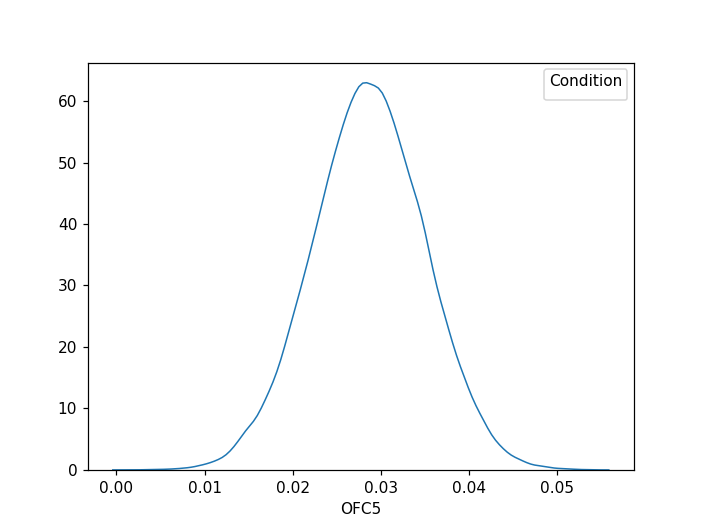

No handles with labels found to put in legend.


NameError: name 'roi' is not defined

In [53]:
%matplotlib notebook
    

        #plt.figure(figsize=(20,10))
        #fig = plt.subplots(figsize=(20,15))
        #Draw the density plot
sns.distplot(k_dict_OFC5_df['OFC5'], hist = False, kde = True,
             kde_kws = {'linewidth': 1})
    
    
plt.legend(prop={'size': 8}, title = 'Condition')
plt.title(str(roi))
plt.xlabel('Bootstrapped mean')
plt.ylabel('Probibility density')
plt.xlim(-4,4)
plt.axvline(linewidth=1, linestyle='--',color='k')
#plt.savefig(os.path.join('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Plots', save_name), dpi=250)
    

In [85]:
plot_ket_placebo(k_dict_OFC5_df[k_dict_OFC5_df=='OFC5'], ofc5)

C:\Users\canlab\Anaconda3\envs\py37\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


NameError: name 'ofc5' is not defined

## Heatmap for bootstrap results

calculate mean of the bootstrap distribution

In [54]:
k_dict_s24_mean =np.mean(k_dict_s24_df)
p_dict_s24_mean =np.mean(p_dict_s24_df)
k_p_dict_s24_mean =np.mean(k_p_dict_s24_df)

In [55]:
k_s24= pd.DataFrame(k_dict_s24_mean, columns=['Bootstrap_mean'])
p_s24= pd.DataFrame(p_dict_s24_mean, columns=['Bootstrap_mean'])
k_p_s24= pd.DataFrame(k_p_dict_s24_mean, columns=['Bootstrap_mean'])

In [56]:
k_dict_s32_mean =np.mean(k_dict_s32_df)
p_dict_s32_mean =np.mean(p_dict_s32_df)
k_p_dict_s32_mean =np.mean(k_p_dict_s32_df)

In [57]:
k_s32= pd.DataFrame(k_dict_s32_mean, columns=['Bootstrap_mean'])
p_s32= pd.DataFrame(p_dict_s32_mean, columns=['Bootstrap_mean'])
k_p_s32= pd.DataFrame(k_p_dict_s32_mean, columns=['Bootstrap_mean'])

In [58]:
k_dict_p32_mean =np.mean(k_dict_p32_df)
p_dict_p32_mean =np.mean(p_dict_p32_df)
k_p_dict_p32_mean =np.mean(k_p_dict_p32_df)

In [59]:
k_p32= pd.DataFrame(k_dict_p32_mean, columns=['Bootstrap_mean'])
p_p32= pd.DataFrame(p_dict_p32_mean, columns=['Bootstrap_mean'])
k_p_p32= pd.DataFrame(k_p_dict_p32_mean, columns=['Bootstrap_mean'])

In [60]:
k_dict_OFC5_mean =np.mean(k_dict_OFC5_df)
p_dict_OFC5_mean =np.mean(p_dict_OFC5_df)
k_p_dict_OFC5_mean =np.mean(k_p_dict_OFC5_df)

In [61]:
k_OFC5= pd.DataFrame(k_dict_OFC5_mean, columns=['Bootstrap_mean'])
p_OFC5= pd.DataFrame(p_dict_OFC5_mean, columns=['Bootstrap_mean'])
k_p_OFC5= pd.DataFrame(k_p_dict_OFC5_mean, columns=['Bootstrap_mean'])

In [62]:
s24_df = pd.concat([k_s24, p_s24, k_p_s24], axis=1)
s24_df.columns=['Ketamine', 'Placebo', 'Ketamine-Placebo']
s24_df

,Ketamine,Placebo,Ketamine-Placebo
OFC1,0.831473,-0.752964,1.583880
OFC2,0.586698,-0.700612,1.288219
OFC3,0.711996,-0.798400,1.509927
OFC4,0.702475,-0.788820,1.492590
OFC5,0.954709,-0.901867,1.857414
OFC6,1.292979,-0.919292,2.210859
OFC7,1.294250,-0.921296,2.216746
FP2,-0.009440,0.175376,-0.186056
25,0.507616,-0.730994,1.238999
s24,0.293444,-0.373143,0.666692


In [63]:
s32_df = pd.concat([k_s32, p_s32, k_p_s32], axis=1)
s32_df.columns=['Ketamine', 'Placebo', 'Ketamine-Placebo']
s32_df

,Ketamine,Placebo,Ketamine-Placebo
OFC1,0.498229,-0.583109,1.080962
OFC2,0.153038,-0.475208,0.627766
OFC3,0.211645,-0.629774,0.841994
OFC4,0.223260,-0.646646,0.870043
OFC5,0.464864,-0.757606,1.222100
OFC6,0.792406,-0.776291,1.568283
OFC7,0.811348,-0.774850,1.586353
FP2,0.503792,0.073518,0.430355
25,-0.011865,-0.517854,0.505375
s24,0.371753,-0.106624,0.478089


In [64]:
p32_df = pd.concat([k_p32, p_p32, k_p_p32], axis=1)
p32_df.columns=['Ketamine', 'Placebo', 'Ketamine-Placebo']
p32_df

,Ketamine,Placebo,Ketamine-Placebo
OFC1,1.123771,-0.466302,1.590114
OFC2,0.800652,-0.337171,1.137923
OFC3,0.962494,-0.477180,1.439925
OFC4,1.147038,-0.530401,1.677394
OFC5,1.391924,-0.640667,2.032535
OFC6,1.673837,-0.659868,2.333347
OFC7,1.695625,-0.650320,2.346069
FP2,-0.139336,0.080526,-0.219638
25,0.637586,-0.367768,1.005084
s24,-0.002469,0.235778,-0.238184


In [65]:
OFC5_df = pd.concat([k_OFC5, p_OFC5, k_p_OFC5], axis=1)
OFC5_df.columns=['Ketamine', 'Placebo', 'Ketamine-Placebo']
OFC5_df

,Ketamine,Placebo,Ketamine-Placebo
OFC1,-0.135442,-0.166643,0.031453
OFC2,0.027058,-0.296405,0.323594
OFC3,0.176390,-0.189534,0.365831
OFC4,0.231814,-0.105775,0.337654
OFC5,0.028655,0.036814,-0.008261
OFC6,0.115849,0.006265,0.109672
OFC7,0.016865,0.065082,-0.048271
FP2,1.000365,-0.723582,1.724103
25,0.288302,-0.269370,0.557645
s24,0.989018,-0.880154,1.869171


<IPython.core.display.Javascript object>


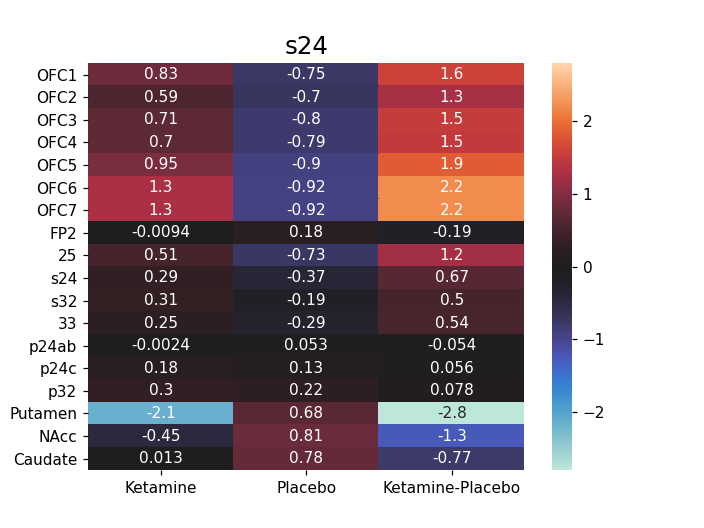

In [66]:
%matplotlib notebook
sns.heatmap(s24_df, vmin=-2.8, vmax=2.8, center=0, annot=True)
plt.title('s24', fontsize=16)
plt.savefig('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Plots/Between_ROIs_bootstrap_heatmap_s24_rightLabeling', dpi=250)

<IPython.core.display.Javascript object>


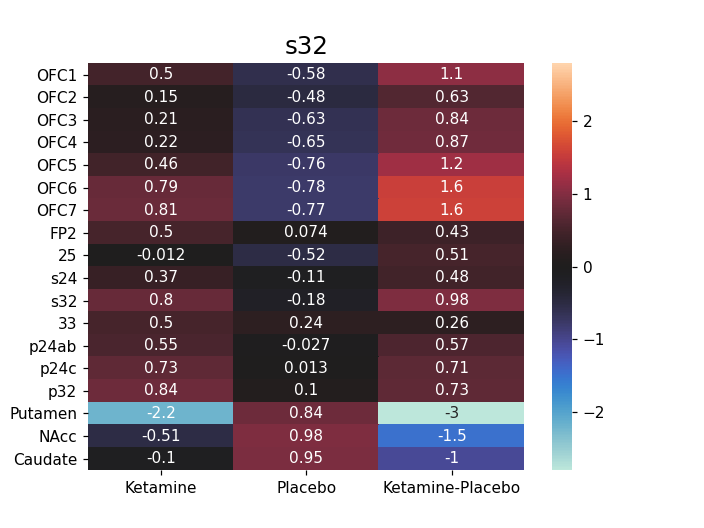

In [67]:
%matplotlib notebook
sns.heatmap(s32_df, vmin=-2.8, vmax=2.8, center=0, annot=True)
plt.title('s32', fontsize=16)
plt.savefig('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Plots/Between_ROIs_bootstrap_heatmap_s32_rightLabeling', dpi=250)

<IPython.core.display.Javascript object>


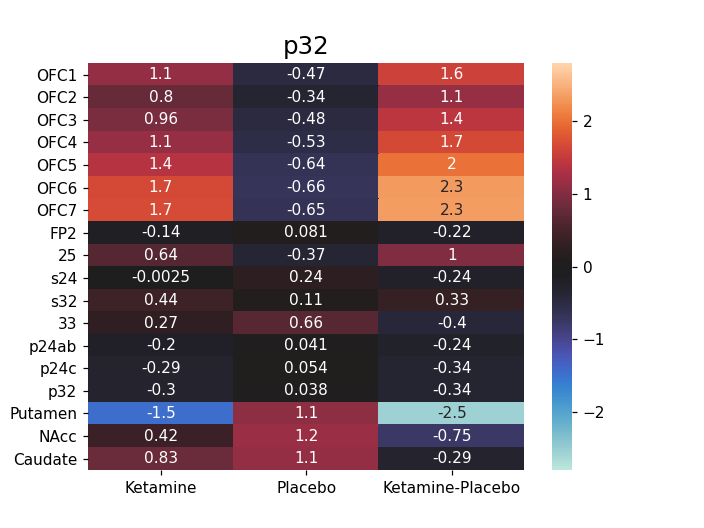

In [68]:
%matplotlib notebook
sns.heatmap(p32_df, vmin=-2.8, vmax=2.8, center=0, annot=True)
plt.title('p32', fontsize=16)
plt.savefig('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Plots/Between_ROIs_bootstrap_heatmap_p32_rightLabeling', dpi=250)

<IPython.core.display.Javascript object>


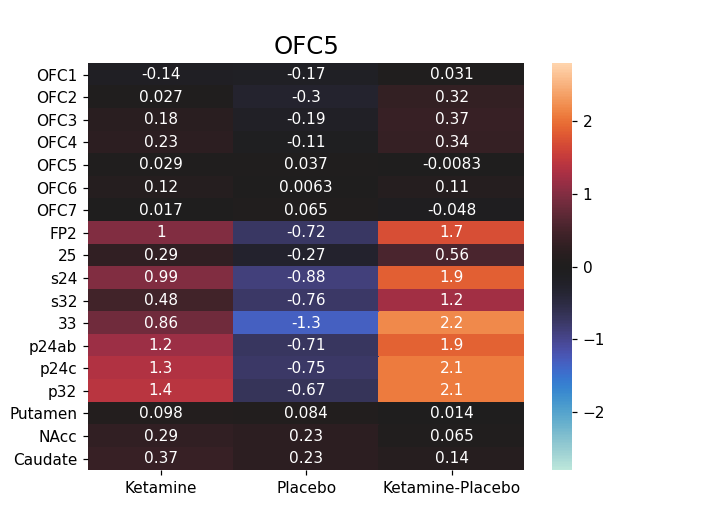

In [69]:
%matplotlib notebook
sns.heatmap(OFC5_df, vmin=-2.8, vmax=2.8, center=0, annot=True)
plt.title('OFC5', fontsize=16)
plt.savefig('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Plots/Between_ROIs_bootstrap_heatmap_OFC5_rightLabeling', dpi=250)